In [1]:
from decimal import Decimal
import decimal

from fimdp.core import ConsMDP
from fimdp.products import product_energy
from fimdp.energy_solver import BasicES

# Explicit representation of energy level in state-space

The goal of this notebook is to show the impact on state-space size if we encode the information about energy levels directly in the state-space. We first need a function, that does this encoding. 

Let's create a CMDP, we will use the following function for easier definitions of actions using uniform distributions.

In [2]:
def uniform(dests):
    """Create a uniform distribution for given destinations.
    
    dests: iterable of states
    """
    count = len(dests)
    mod = 100 % count
    decimal.getcontext().prec = 2
    prob = Decimal(1)/Decimal(count)
    dist = {i: prob for i in dests}
    last = dests[-1]
    dist[last] = dist[last] + Decimal("0.01")*mod
    return dist

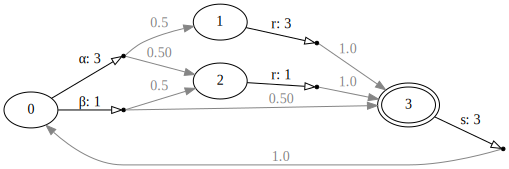

In [3]:
mdp = ConsMDP()
mdp.new_states(4)
mdp.set_reload(3)
mdp.add_action(0, uniform([1,2]), "α", 3)
mdp.add_action(0, uniform([2,3]), "β", 1)
mdp.add_action(1, uniform([3]), "r", 3)
mdp.add_action(2, uniform([3]), "r", 1)
mdp.add_action(3, uniform([0]), "s", 3)
mdp.get_Buchi([1,2], 5, True)
mdp

## Product of CMDP and energy counter

The state-space of the newly created MDP consists of tuples $(s, e)$, where $s$ is the state of the input CMDP and $e$ is the energy level. For a tuple-state $(s,e)$ and an action $a$ with consumption (in the input CMDP) $c$, all successors of the action $a$ in the new MDP are of the form $(s', e-c)$ for non-reload states and $(r,\mathsf{cap})$ for reload states.

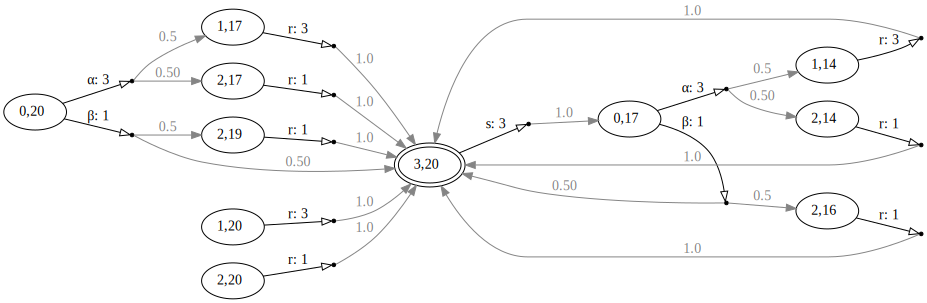

In [4]:
p, _ = product_energy(mdp, 20)
p

## Comparison to our approach
We take the NYC case study and test the running time for MEC-decomposition (part of almost-sure Büchi algo), and compute Büchi using our approach for several capacities. Please note that the running times for computing the set of explicit-states would be still larger than just the time needed for the MEC-decomposition.

In [5]:
from fimdpenv.NYCEnv import parse
#from fimdpenv import NYCtools
from fimdp.mec_decomposition import get_MECs

m, T = parse('../examples/NYCstreetnetwork.json')

In [6]:
print(f"The consMDP has {m.num_states} states and {len(m.actions)} actions for arbitrary capacity.")

The consMDP has 7378 states and 8473 actions for arbitrary capacity.


In [7]:
def explicit_mecs(consMDP, cap):
    p, TT = product_energy(consMDP, cap, T)
    %timeit mecs = get_MECs(p)
    mecs = get_MECs(p)
    print(f"The explicit MDP has {p.num_states} states and {len(p.actions)} actions for capacity {cap}.")
    print(f"There are {len(mecs)} MECs.")

In [8]:
explicit_mecs(m, 20)

1.34 s ± 92.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The explicit MDP has 69881 states and 80414 actions for capacity 20.
There are 11 MECs.


In [9]:
explicit_mecs(m, 40)

8.86 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The explicit MDP has 187932 states and 216214 actions for capacity 40.
There are 18 MECs.


In [10]:
explicit_mecs(m, 60)

46.1 s ± 1.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
The explicit MDP has 311301 states and 358066 actions for capacity 60.
There are 11 MECs.


In [11]:
explicit_mecs(m, 80)

3min 45s ± 13.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
The explicit MDP has 434885 states and 500162 actions for capacity 80.
There are 4 MECs.


In [12]:
solver = BasicES(m, 20, T)
%timeit solver.get_Buchi(recompute=True)

2.21 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
solver = BasicES(m, 40, T)
%timeit solver.get_Buchi(recompute=True)

4.49 s ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
solver = BasicES(m, 60, T)
%timeit solver.get_Buchi(recompute=True)

5.11 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
solver = BasicES(m, 80, T)
%timeit solver.get_Buchi(recompute=True)

2.44 s ± 77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
